# 2-dim classification tests using simulated data

- General setup
- Loss distributions under different initial values
- Impact of directionality on learning

## General setup

In [1]:
## External modules.
from copy import deepcopy
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
from os import path
from scipy.optimize import minimize_scalar

## Internal modules.
from mml.algos.gd import GD_ERM
from mml.losses.cvar import CVaR
from mml.losses.logistic import Logistic_Binary
from mml.losses.margin import Margin_Binary
from mml.losses.quadratic import Quadratic
from mml.losses.tilted import Tilted
from mml.models.linreg import LinearRegression
from mml.utils import makedir_safe
from setup_algos import GD_ERM_Tilted
from setup_dispersions import get_dispersion
from setup_losses import R_Risk, T_Risk
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend
from setup_sims import bracket_prep, get_obfn
from setup_train import train_epoch

In [2]:
## Create directory to save figures.
makedir_safe(img_dir)

In [3]:
## Prepare seed sequence; lets us align datasets across different tests.
entropy = 21281555010861417500927421083615113141
ss = np.random.SeedSequence(entropy=entropy)

In [4]:
## Scenario specification.
scenario = "gaussian-spherical-unbalanced"

In [5]:
## Set up random generator.
rg_common = np.random.default_rng(seed=ss)

In [6]:
## Setup up base losses.
loss_logistic = Logistic_Binary()
loss_hinge = Margin_Binary(hinge=True, threshold=0.0)
loss_unhinged = Margin_Binary(hinge=False, threshold=0.0)

In [7]:
## Scenario details.

label_noise = False
fraction_to_flip = 0.01
label_noise_name = "noisy" if label_noise else "noiseless"

if scenario == "uniform-nearby-noisefree":
    
    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "uniform-square"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 100
    
    ## Algorithm parameters.
    step_size = 0.01
    num_steps = 20000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)}
    
    ## Manually set limits.
    set_limits = True
    y_top = 1.5 + shift_vert
    y_bottom = -0.5 - shift_vert
    x_right = 1.5 + shift_horiz
    x_left = -0.5 - shift_horiz
    
elif scenario == "gaussian-spherical":

    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "gaussian-spherical"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 100
    
    ## Algorithm parameters.
    step_size = 0.01
    num_steps = 20000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)}
    
    ## Manually set limits.
    set_limits = False
    y_top = 1.0 + shift_vert
    y_bottom = -1.0 - shift_vert
    x_right = 1.0 + shift_horiz
    x_left = -1.0 - shift_horiz

elif scenario == "gaussian-spherical-unbalanced":

    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "gaussian-spherical-unbalanced"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 500
    frac_pos = 0.95
    frac_neg = 1.0-frac_pos
    
    ## Algorithm parameters.
    step_size = 0.2
    num_steps = 10000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)} # perpendicular to true line.
    
    ## Manually set limits.
    set_limits = True
    y_top = 1.25 + shift_vert
    y_bottom = -1.25 - shift_vert
    x_right = 1.25 + shift_horiz
    x_left = -1.25 - shift_horiz

elif scenario == "gaussian-asymmetric":

    ## Basic labeller.
    w_star = np.array([-1.0, 1.0])
    w_0_star = 0.0
    
    ## Feature distribution.
    feature_type = "gaussian-asymmetric"
    
    ## Label assignment.
    label_type = "hplane"
    
    ## Shifting of the features (positive pushes apart, negative merges).
    shift_horiz = 0.0
    shift_vert = 0.0
    
    ## Sample size.
    n_tr = 100
    
    ## Algorithm parameters.
    step_size = 0.01
    num_steps = 20000
    
    ## Initial value.
    paras_init = {"w": np.array([1.0, 1.0, 0.0]).reshape(3,1)}
    
    ## Manually set limits.
    set_limits = False
    y_top = 1.0 + shift_vert
    y_bottom = -1.0 - shift_vert
    x_right = 1.0 + shift_horiz
    x_left = -1.0 - shift_horiz
    
else:
    raise ValueError("Provide a proper scenario name.")


In [8]:
## Helper functions and clerical variables.

def uniform_square(n, rg):
    '''
    Generate inputs in a uniform fashion on the unit square.
    '''
    return rg.uniform(size=(n,2))


def gaussian_spherical(n, rg):
    mean_positive = np.array([-0.25, 0.25])
    mean_negative = np.array([0.25, -0.25])
    cov = np.vstack([[0.01,0.0], [0.0,0.01]])
    return np.vstack([rg.multivariate_normal(mean=mean_positive, cov=cov, size=n//2),
                      rg.multivariate_normal(mean=mean_negative, cov=cov, size=n//2)])


def gaussian_spherical_unbalanced(npos, nneg, rg):
    mean_positive = np.array([-0.25, 0.25])
    mean_negative = np.array([0.25, -0.25])
    cov = np.vstack([[0.01,0.0], [0.0,0.01]])
    return np.vstack([rg.multivariate_normal(mean=mean_positive, cov=cov, size=npos),
                      rg.multivariate_normal(mean=mean_negative, cov=cov, size=nneg)])


def gaussian_asymmetric(n, rg):
    mean_positive = np.array([-0.25, 0.25]).reshape(1,2)
    mean_negative = np.array([0.25, -0.25]).reshape(1,2)
    rad_positive = -np.pi/4.0
    rad_negative = np.pi/4.0
    cov = np.vstack([[0.001, 0.0], [0.0, 0.05]])
    rotate_positive = np.vstack([[np.cos(rad_positive), -np.sin(rad_positive)],
                                 [np.sin(rad_positive), np.cos(rad_positive)]])
    rotate_negative = np.vstack([[np.cos(rad_negative), -np.sin(rad_negative)],
                                 [np.sin(rad_negative), np.cos(rad_negative)]])
    out_positive = np.matmul(rotate_positive,
                             rg.multivariate_normal(mean=mean_positive.reshape(-1),
                                                    cov=cov, size=n//2).T).T
    out_positive += mean_positive
    out_negative = np.matmul(rotate_negative,
                             rg.multivariate_normal(mean=mean_negative.reshape(-1),
                                                    cov=cov, size=n//2).T).T
    out_negative += mean_negative
    
    return np.vstack([out_positive, out_negative])


def linear_separator(X):
    '''
    Assign labels based on a pre-specified hyperplane.
    '''
    return np.where(np.dot(X, w_star) >= w_0_star, 1, 0).reshape(len(X),1)

color_standard = "xkcd:purple"
color_mresid = "xkcd:green"
color_mresid1way = "xkcd:blue green"
color_cvar = "xkcd:orange"
color_tilted = "xkcd:crimson"

In [9]:
## Function for generating inputs and labels.

def get_generate_features(feature_type, rg):
    if feature_type == "uniform-square":
        return lambda n: uniform_square(n=n, rg=rg)
    elif feature_type == "gaussian-spherical":
        return lambda n: gaussian_spherical(n=n, rg=rg)
    elif feature_type == "gaussian-spherical-unbalanced":
        return lambda n: gaussian_spherical_unbalanced(npos=int(n*frac_pos), nneg=int(n*frac_neg), rg=rg)
    elif feature_type == "gaussian-asymmetric":
        return lambda n: gaussian_asymmetric(n=n, rg=rg)
    else:
        raise ValueError("Did not recognize feature_type given.")

def get_assign_labels(label_type, rg):
    if label_type == "hplane":
        return lambda X: linear_separator(X=X)
    else:
        raise ValueError("Did not recognize label_type given.")

In [10]:
## Generate some training data.
generate_features = get_generate_features(feature_type=feature_type, rg=rg_common)
assign_labels = get_assign_labels(label_type=label_type, rg=rg_common)
X_tr = generate_features(n=n_tr)
y_tr = assign_labels(X=X_tr)

## If desired, randomly flip some labels.
if label_noise:
    num_to_flip = int(np.ceil(fraction_to_flip*len(X_tr)))
    idx_to_flip = rg_common.choice(a=len(X_tr), size=num_to_flip)
    y_tr[idx_to_flip,:] = np.where(y_tr[idx_to_flip,:] == 1, 0, 1)

## Organize the positive and negative classes.
idx_positive = y_tr.reshape(-1) == 1
idx_negative = y_tr.reshape(-1) == 0
y_tr_pmone = np.where(y_tr == 1, y_tr, -1) # set to plus/minus 1.

## Shifting (note the signs).
X_tr[idx_positive,0] -= shift_horiz
X_tr[idx_positive,1] += shift_vert
X_tr[idx_negative,0] += shift_horiz
X_tr[idx_negative,1] -= shift_vert

## Pad the training features with -1.
X_tr_padded = np.hstack([X_tr, -np.ones((len(X_tr),1), dtype=X_tr.dtype)]) # pad with -1.

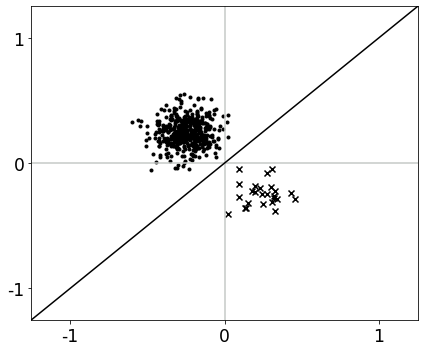

In [11]:
## Visualize the labelled training data.
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
x_values = np.linspace(x_left, x_right, 100)
y_values = (w_0_star/w_star[1]) - (w_star[0]/w_star[1])*x_values
ax.plot(x_values, y_values, color="xkcd:black")
ax.scatter(X_tr[idx_positive,0], X_tr[idx_positive,1], marker=".", color="xkcd:black")
ax.scatter(X_tr[idx_negative,0], X_tr[idx_negative,1], marker="x", color="xkcd:black")
ax.tick_params(labelsize=my_fontsize)
if set_limits:
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.set_xlim(left=x_left, right=x_right)
ticks = [-1.0, 0.0, 1.0]
tick_labels = ["-1", "0", "1"]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)
fname = path.join(img_dir, "class2d_{}_{}.{}".format(scenario, label_noise_name, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

## Loss distributions under different initial values

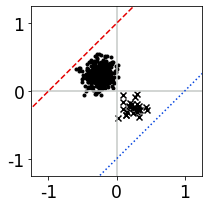

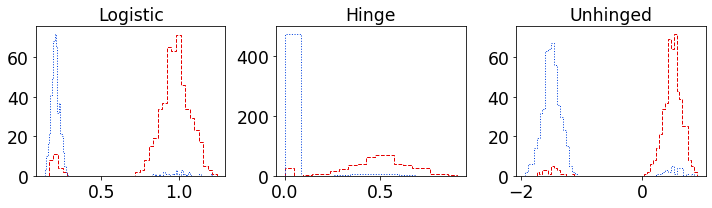

In [12]:
## Visualize some alternative candidates and their loss distributions.

w_init_bad_1 = np.array([-1.0, 1.0, 1.0]).reshape(3,1)
w_init_bad_2 = np.array([-1.0, 1.0, -1.0]).reshape(3,1)
paras_init_bad_1 = {"w": w_init_bad_1}
paras_init_bad_2 = {"w": w_init_bad_2}

model_1 = LinearRegression(num_features=X_tr_padded.shape[1],
                           paras_init=deepcopy(paras_init_bad_1),
                           rg=rg_common)
model_2 = LinearRegression(num_features=X_tr_padded.shape[1],
                           paras_init=deepcopy(paras_init_bad_2),
                           rg=rg_common)

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
x_values = np.linspace(x_left-0.5, x_right+0.5, 100)
y_values_1 = (w_init_bad_1[2]/w_init_bad_1[1]) - (w_init_bad_1[0]/w_init_bad_1[1])*x_values
y_values_2 = (w_init_bad_2[2]/w_init_bad_2[1]) - (w_init_bad_2[0]/w_init_bad_2[1])*x_values
ax.plot(x_values, y_values_1, color="xkcd:red", ls="dashed")
ax.plot(x_values, y_values_2, color="xkcd:blue", ls="dotted")
ax.scatter(X_tr[idx_positive,0], X_tr[idx_positive,1], marker=".", color="xkcd:black")
ax.scatter(X_tr[idx_negative,0], X_tr[idx_negative,1], marker="x", color="xkcd:black")
ax.tick_params(labelsize=my_fontsize)
if set_limits:
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.set_xlim(left=x_left, right=x_right)
ticks = [-1.0, 0.0, 1.0]
tick_labels = ["-1", "0", "1"]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)
fname = path.join(img_dir, "class2d_{}_{}_badinits.{}".format(scenario, label_noise_name, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3), sharey=False)
ax1.hist(loss_logistic(model=model_1, X=X_tr_padded, y=y_tr_pmone),
         bins="auto", color="xkcd:red", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax1.hist(loss_logistic(model=model_2, X=X_tr_padded, y=y_tr_pmone),
         bins="auto", color="xkcd:blue", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax1.set_title("Logistic", size=my_fontsize)
ax1.tick_params(labelsize=my_fontsize)
ax2.hist(loss_hinge(model=model_1, X=X_tr_padded, y=y_tr_pmone),
         bins="auto", color="xkcd:red", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax2.hist(loss_hinge(model=model_2, X=X_tr_padded, y=y_tr_pmone),
         bins="auto", color="xkcd:blue", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax2.set_title("Hinge", size=my_fontsize)
ax2.tick_params(labelsize=my_fontsize)
ax3.hist(loss_unhinged(model=model_1, X=X_tr_padded, y=y_tr_pmone),
         bins="auto", color="xkcd:red", ls="dashed", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax3.hist(loss_unhinged(model=model_2, X=X_tr_padded, y=y_tr_pmone),
         bins="auto", color="xkcd:blue", ls="dotted", histtype="step",
         fill=False, hatch=None, orientation="vertical", density=False)
ax3.set_title("Unhinged", size=my_fontsize)
ax3.tick_params(labelsize=my_fontsize)
fname = path.join(img_dir, "class2d_{}_{}_lossdists.{}".format(scenario, label_noise_name, my_ext))
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

In [13]:
## Setup of risk hyperparameters.
todo_risks = ["rrisk", "trisk", "trisk1way", "cvar", "entropic", "dro"]
todo_riskparas = {
    "rrisk": ("alpha", 1.0),
    "trisk": ("alpha", 1.0),
    "trisk1way": ("alpha", 1.0),
    "cvar": ("prob", 0.5),
    "entropic": ("gamma", 2.0),
    "dro": ("atilde", 0.5)
}
aux_riskparas = {
    "rrisk": {"sigma": 0.5, "eta": 1.0},
    "trisk": {"sigma": 0.5, "etatilde": 0.99},
    "trisk1way": {"sigma": 0.5, "etatilde": 0.99},
    "cvar": {},
    "entropic": {},
    "dro": {}
}

In [14]:
## Clerical parameters.
tolerance = 1e-10
verbose = True

In [15]:
## Pick a base loss.
loss_base = loss_logistic

In [16]:
## Setup of storage.
storage = {"model_1": {}, "model_2": {}}

In [17]:
## Compute all the empirical risks for each of the preceding loss distributions.

## Loop over risk classes.
for risk in todo_risks:
    
    ## Get the risk ready.
    pname, riskpara = todo_riskparas[risk]
    aux_paras = aux_riskparas[risk]
    aux_paras[pname] = riskpara
    
    ## Set remaining parameter to be passed.
    aux_paras[pname] = riskpara
    
    ## Get the data ready.
    losses_1 = loss_base(model=model_1, X=X_tr_padded, y=y_tr_pmone)
    losses_2 = loss_base(model=model_2, X=X_tr_padded, y=y_tr_pmone)
    
    ## Prepare objective function.
    obfn = get_obfn(name=risk)
    
    ## Prepare brackets and run optimization for each model.
    bracket_low, bracket_mid, bracket_high = bracket_prep(
        x=losses_1, paras=aux_paras, obfn_name=risk, verbose=verbose
    )
    opt_result = minimize_scalar(fun=obfn,
                                 bracket=(bracket_low, bracket_mid, bracket_high),
                                 bounds=(bracket_low, bracket_high),
                                 args=(losses_1, aux_paras),
                                 method="bounded",
                                 options={"xatol": tolerance})
    storage["model_1"][risk] = opt_result.fun
    bracket_low, bracket_mid, bracket_high = bracket_prep(
        x=losses_2, paras=aux_paras, obfn_name=risk, verbose=verbose
    )
    opt_result = minimize_scalar(fun=obfn,
                                 bracket=(bracket_low, bracket_mid, bracket_high),
                                 bounds=(bracket_low, bracket_high),
                                 args=(losses_2, aux_paras),
                                 method="bounded",
                                 options={"xatol": tolerance})
    storage["model_2"][risk] = opt_result.fun

Bracket prep (trisk): extending MIN side.
Bracket prep (trisk): extending MIN side.
Bracket prep (trisk1way): extending MIN side.
Bracket prep (trisk1way): extending MIN side.
Bracket prep (dro): extending MIN side.


___